In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from community_simulator.usertools import (MakeConsumerDynamics, MakeResourceDynamics,  MakeParams,
                                           MakeMatrices, MakeInitialState, a_default)
from community_simulator import Community
from community_simulator.visualization import PlotTraj, StackPlot
import pickle
from biom import Table, load_table
from scipy.spatial.distance import pdist, squareform
from skbio.stats.ordination import pcoa
%matplotlib inline

from torchdiffeq import odeint_adjoint as odeint
from torch_bnn import BNN
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import tqdm

In [2]:
!ls

C.txt  neural-ode.ipynb  __pycache__	   split.ipynb
data   N.txt		 R.txt		   torch_bnn.py
D.txt  preprocess.ipynb  simple-sim.ipynb


In [3]:
C = pd.read_table('data/C.txt', index_col=[0, 1], header=[0, 1])
D = pd.read_table('data/D.txt', index_col=[0, 1], header=[0, 1])
N = pd.read_table('data/N.txt', index_col=[0, 1, 2], header=[0, 1])
R = pd.read_table('data/R.txt', index_col=[0, 1, 2], header=[0, 1])

In [4]:
wells = np.unique(N.index.get_level_values(0))
time = np.unique(N.reset_index()['time'])

n, r = N.shape[1], R.shape[1]
nr = n + r

idx = np.random.random(len(wells)) < 0.5
train_wells = wells[idx]
test_wells = wells[~idx]

In [5]:
class ODEFunc(nn.Module):

    def __init__(self, nr):
        super(ODEFunc, self).__init__()

        self.net = nn.Sequential(
            nn.Linear(nr, 10),
            nn.Tanh(),
            nn.Linear(10, nr),
        )

        for m in self.net.modules():
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, mean=0, std=0.1)
                nn.init.constant_(m.bias, val=0.1)
        self.y0 = nn.Parameter(torch.ones(nr), requires_grad=True).cuda()

    def forward(self, t, y):
        return self.net(y**3)


def loss_f(pred, data):
    # aitchison distance for error quantification
    loss__f = nn.MSELoss(reduction='mean')
    pred = F.softmax(pred)
    pred, data = torch.log(pred), torch.log(data + 1e-5)
    pred = pred - pred.mean(axis=1).view(-1, 1)
    data = data - data.mean(axis=1).view(-1, 1)
    err = loss__f(pred, data)
    #err = torch.sum((pred - data)**2, axis=1).mean()
    return err

In [6]:
# TODO: Build NN / BNN to draw function
# Figure out initial value
func = ODEFunc(nr).cuda()
t = torch.Tensor(time).cuda()

optimizer = optim.Adam(list(func.parameters()), lr=1e-2)

In [7]:
NRtraj = []
epochs = 10
train_loss, test_loss = [], []

for _ in tqdm.tqdm(range(epochs)):
    losses = []
    train_wells = np.random.permutation(train_wells)
    
    for i, w in enumerate(train_wells):
        # forward pass
        optimizer.zero_grad()
        idx = N.reset_index()['index'] == w
        sN = N.reset_index().loc[idx].set_index(['index', 'time', 'round'])
        sR = R.reset_index().loc[idx].set_index(['index', 'time', 'round'])
        data = torch.Tensor(np.hstack((sN.values, sR.values))).cuda()
        pred = odeint(func, func.y0, t)
        loss = loss_f(pred, data)
        
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
    train_loss.append(np.mean(losses))
    
    losses = []
    for w in test_wells:
        with torch.no_grad():
            idx = N.reset_index()['index'] == w
            sN = N.reset_index().loc[idx].set_index(['index', 'time', 'round'])
            sR = R.reset_index().loc[idx].set_index(['index', 'time', 'round'])
            data = torch.Tensor(np.hstack((sN.values, sR.values))).cuda()
            pred = odeint(func, func.y0, t)
            loss = loss_f(pred, data)
            losses.append(loss.item())
    test_loss.append(np.mean(losses))

  0%|          | 0/10 [00:00<?, ?it/s]<ipython-input-5-54c8fc79eb65>:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred = F.softmax(pred)
100%|██████████| 10/10 [11:42<00:00, 70.28s/it]


Text(0, 0.5, 'Mean Squared Error')

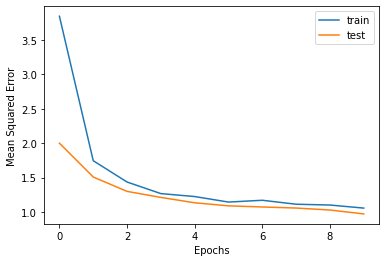

In [8]:
plt.plot(train_loss, label='train')
plt.plot(test_loss, label='test')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error')

In [9]:
preds = []
w = test_wells[0]
with torch.no_grad():
    idx = N.reset_index()['index'] == w
    sN = N.reset_index().loc[idx].set_index(['index', 'time', 'round'])
    sR = R.reset_index().loc[idx].set_index(['index', 'time', 'round'])
    data = torch.Tensor(np.hstack((sN.values, sR.values))).cuda()
    pred = odeint(func, func.y0, t)
    pred = pred.detach().cpu().numpy()

In [10]:
pred = pd.DataFrame(pred, columns=pd.MultiIndex.from_tuples(list(sN.columns) + list(sR.columns)))

In [11]:
from skbio.stats.composition import closure, clr
sNv, sRv = sN.values, sR.values
sNv[sNv<=0] = 1e-5
sRv[sRv<=0] = 1e-5

true = pd.DataFrame(np.hstack((clr(sNv), clr(sRv))), 
                    columns=pd.MultiIndex.from_tuples(list(sN.columns) + list(sR.columns)))

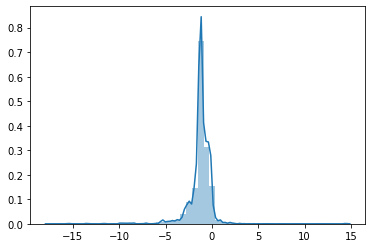

In [12]:
sns.distplot((true - pred).values.ravel())

Text(0.5, 0, 'Error')

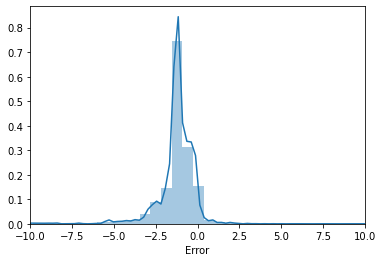

In [13]:
sns.distplot((true - pred).values.ravel())
plt.xlim([-10, 10])
plt.xlabel('Error')

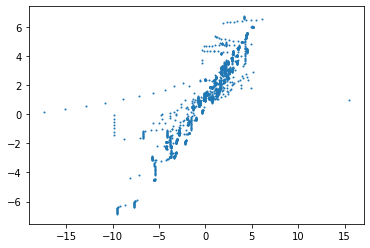

In [14]:
plt.scatter(true.values.ravel(), pred.values.ravel(), s=1)

Text(0, 0.5, 'Prediction')

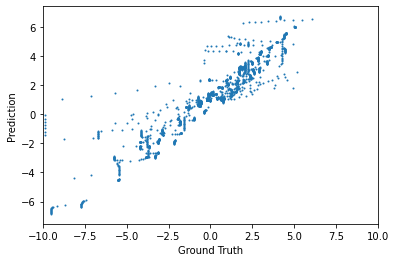

In [20]:
plt.scatter(true.values.ravel(), pred.values.ravel(), s=1)
plt.xlim([-10, 10])
plt.xlabel('Ground Truth')
plt.ylabel('Prediction')

In [16]:
func.y0.shape

torch.Size([95])

In [17]:
t.shape

torch.Size([20])

In [18]:
pred.shape

(20, 95)

In [19]:
list(func.parameters())

[Parameter containing:
 tensor([[ 1.0673e-01,  2.9435e-02,  8.2776e-02,  8.2336e-02,  7.4115e-02,
          -3.2176e-02,  7.9794e-02,  5.0173e-02,  5.6389e-03, -1.3599e-01,
           7.7724e-03,  7.8509e-02, -9.4980e-02,  4.4039e-02,  1.0900e-01,
          -9.9193e-04,  7.9436e-02,  1.0186e-01, -3.5211e-02,  8.1607e-02,
           1.9307e-02,  8.2337e-02,  2.1847e-01, -1.7280e-01,  1.1404e-01,
           1.2628e-01,  9.5365e-02, -2.7489e-02,  6.2297e-02,  2.0116e-01,
           3.1384e-01,  2.2677e-01,  1.4349e-01,  9.4817e-03, -1.3444e-01,
          -9.7994e-02,  2.0234e-01,  1.1081e-01,  2.3421e-01,  1.2818e-01,
          -2.6434e-02,  9.3660e-02,  2.9418e-01,  1.8609e-02,  3.6757e-02,
           1.8098e-01,  1.6369e-01,  4.5575e-02, -1.5089e-02,  6.8332e-02,
           2.0187e-01,  1.7637e-01, -4.3006e-02, -9.3232e-03,  4.2410e-02,
           2.2337e-01, -8.0283e-02,  2.7748e-02,  7.6781e-02,  1.6263e-01,
           8.3603e-02,  5.9993e-02,  1.5445e-01,  8.8763e-02,  1.0104e-01,
  